# Stabilizacja metody elementów skończonych
W tym rozdziale omawiane jest pojęcie **stabilności** metody elementów skończonych (MES), ze szczególnym uwzględnieniem tzw. **warunku inf-sup**. Warunek ten, niezależnie od siebie, sformułowali profesorowie **Ivo Babuška**, **Franco Brezzi** i **Olga Ładyżenska**.

__[artykuł](https://epodreczniki.open.agh.edu.pl/handbook/31/module/713/reader)__

### Algorytm metody elementów skończonych:

1. **Definicja obszaru obliczeń i siatki**
   - Wybór obszaru (np. $\Omega = [0,1]^2$).
   - Generacja siatki (np. 4x4, czyli 16 elementów).
   - Przygotowanie pod funkcje bazowe (np. B-spline).

2. **Wybór równania różniczkowego**
   - $-\Delta u = f$ (równanie Poissona).

3. **Określenie warunków brzegowych**
   - $u = 0$ dla $x = 0$, $y \in (0,1)$  
   - $u = 1$ dla $x = 1$, $y \in (0,1)$  
   - $\frac{\partial u}{\partial y} = 0$ dla $y \in \{0,1\}$, $x \in (0,1)$

4. **Przekształcenie formy silnej na słabą**
   - $b(u,v) = \int_{\Omega} \nabla u \cdot \nabla v \, dx \, dy$
   - $l(v) = \int_{\Omega} x \, v(x,y) \, dx \, dy$

5. **Zdefiniowanie bazy funkcji aproksymacyjnych**
   - Użycie funkcji B-spline drugiego rzędu ($B_{x_{i},2}$, $B_{y_{j},2}$).
   - Przestrzeń aproksymacyjna:  
     $U_h = \text{span}\{ B_{x_{i},2} \cdot B_{y_{j},2} \}$, dla $i,j = 1,\dots,6$

6. **Zdefiniowanie bazy funkcji testujących**
   - Również funkcje B-spline ($B_{x_{k},2}$, $B_{y_{l},2}$).
   - Przestrzeń testująca:  
     $V_h = \text{span}\{ B_{x_{k},2} \cdot B_{y_{l},2} \}$, dla $k,l = 1,\dots,6$

7. **Uformowanie wersji dyskretnej problemu**
   - Sformułowanie słabe dla funkcji bazowych:  
     $b_h(u_h, v_h) = l(v_h)$, dla każdego $v_h \in V_h$
   - Aproksymacja rozwiązania:  
     $u_h = \sum_{i,j=1}^6 u_{i,j} \cdot B_{x_{i},2}(x) \cdot B_{y_{j},2}(x)$  
     $v_h = \sum_{k,l=1}^6 v_{k,l} \cdot B_{x_{k},2}(x) \cdot B_{y_{l},2}(x)$

8. **Zbudowanie układu równań liniowych**
   - Lewa strona (macierz sztywności):
     $$
     \int_{\Omega} \left( \frac{\partial B_{x_{i},2}}{\partial x} \cdot B_{y_{j},2} \cdot \frac{\partial B_{x_{k},2}}{\partial x} \cdot B_{y_{l},2}
     + B_{x_{i},2} \cdot \frac{\partial B_{y_{j},2}}{\partial y} \cdot B_{x_{k},2} \cdot \frac{\partial B_{y_{l},2}}{\partial y} \right)
     $$
   - Prawa strona (wektor siły):
     $$
     \int_{\Omega} x \cdot B_{x_{k},2} \cdot B_{y_{l},2}
     $$

9. **Rozwiązanie układu równań**
   - Użycie np. LU-faktoryzacji z pivotingiem.

10. **Modyfikacja rozwiązania**
    - Korekta wyniku przez odjęcie przesuniętego warunku brzegowego:  
      $u_h = u_h - x$



Wyjaśnienie:

**Funkcja B-spline** to gładka, kawałkami wielomianowa funkcja, zbudowana na podstawie punktów kontrolnych i wektora węzłów. Służy jako funkcja bazowa do aproksymacji bardziej złożonych funkcji lub kształtów.

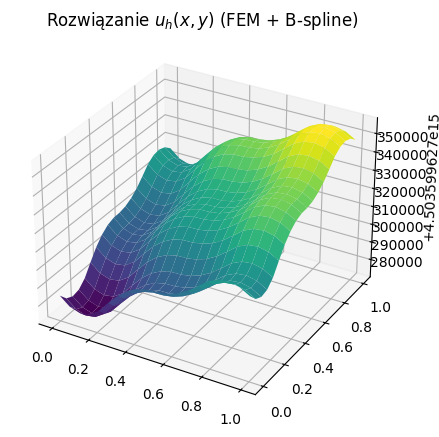

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# Parametry siatki i B-spline
n_elements = 4
degree = 2
n_knots = n_elements + 2 * degree + 1  # z powtórzeniami na końcach
domain = [0, 1]

# Węzły B-spline
def make_knot_vector(n, p):
    interior = np.linspace(0, 1, n - p + 1)
    start = [0] * p
    end = [1] * p
    return np.array(start + list(interior) + end)

knot_vector = make_knot_vector(n_knots - degree - 1, degree)
n_basis = len(knot_vector) - degree - 1

# Siatka punktów (dla integracji)
xq = np.linspace(0, 1, 20)
yq = np.linspace(0, 1, 20)
Xq, Yq = np.meshgrid(xq, yq)
Xq_flat = Xq.flatten()
Yq_flat = Yq.flatten()
weights = np.ones_like(Xq_flat) * (1 / len(Xq_flat))  # równe wagi

# Definicja funkcji bazowych 1D
def bspline_basis(i, p, kv, x):
    coeffs = np.zeros(len(kv) - p - 1)
    coeffs[i] = 1.0
    return BSpline(kv, coeffs, p)(x)

# Gradient funkcji B-spline (przybliżenie)
def grad_bspline_basis(i, p, kv, x, h=1e-6):
    return (bspline_basis(i, p, kv, x + h) - bspline_basis(i, p, kv, x - h)) / (2 * h)

# RHS funkcja f(x, y)
def f(x, y):
    return x  # zgodnie z zadaniem

# Montaż macierzy sztywności i wektora prawej strony
A = lil_matrix((n_basis ** 2, n_basis ** 2))
b = np.zeros(n_basis ** 2)

for i in range(n_basis):
    for j in range(n_basis):
        phi_ij = bspline_basis(i, degree, knot_vector, Xq_flat) * bspline_basis(j, degree, knot_vector, Yq_flat)
        dphi_dx_ij = grad_bspline_basis(i, degree, knot_vector, Xq_flat) * bspline_basis(j, degree, knot_vector, Yq_flat)
        dphi_dy_ij = bspline_basis(i, degree, knot_vector, Xq_flat) * grad_bspline_basis(j, degree, knot_vector, Yq_flat)

        idx_ij = i * n_basis + j

        b[idx_ij] = np.sum(f(Xq_flat, Yq_flat) * phi_ij * weights)

        for k in range(n_basis):
            for l in range(n_basis):
                idx_kl = k * n_basis + l
                dphi_dx_kl = grad_bspline_basis(k, degree, knot_vector, Xq_flat) * bspline_basis(l, degree, knot_vector, Yq_flat)
                dphi_dy_kl = bspline_basis(k, degree, knot_vector, Xq_flat) * grad_bspline_basis(l, degree, knot_vector, Yq_flat)

                A[idx_ij, idx_kl] += np.sum((dphi_dx_ij * dphi_dx_kl + dphi_dy_ij * dphi_dy_kl) * weights)

# Rozwiązanie układu równań
u_vec = spsolve(A.tocsr(), b)

# Rekonstrukcja i wizualizacja rozwiązania
U = np.zeros_like(Xq_flat)
for i in range(n_basis):
    for j in range(n_basis):
        idx = i * n_basis + j
        U += u_vec[idx] * bspline_basis(i, degree, knot_vector, Xq_flat) * bspline_basis(j, degree, knot_vector, Yq_flat)

U = U.reshape(Xq.shape)

# Wizualizacja
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xq, Yq, U, cmap='viridis')
ax.set_title("Rozwiązanie $u_h(x, y)$ (FEM + B-spline)")
plt.show()





---

### Warunek inf-sup – istota stabilności

Warunek inf-sup (ang. *infimum-supremum condition*) jest matematycznym narzędziem służącym do badania stabilności MES. Wyraża się wzorem:

$$
\inf_{u \in U} \sup_{v \in V} \frac{b_h(u,v)}{\|u\| \cdot \|v\|} = \gamma > 0
$$

Może być formułowany zarówno w przestrzeniach:
- nieskończenie wymiarowych (ciągłe rozwiązania),
- jak i skończenie wymiarowych (dyskretne przybliżenia przy użyciu np. B-spline’ów).

---

### Problemy

- Nawet jeśli warunek inf-sup jest spełniony w przestrzeni nieskończenie wymiarowej, **może on nie być spełniony** w przestrzeni dyskretnej (np. przy złym wyborze przestrzeni testującej $V_h$).
- Wówczas:
  - układ równań może być **nierozwiązywalny**,
  - albo jego rozwiązanie będzie **niestabilne** (np. wystąpią oscylacje numeryczne).

---

### Stabilność układu równań

Jeśli warunek:

$$
\inf_{u_h \in U_h} \sup_{v_h \in V_h} \frac{b_h(u_h, v_h)}{\|u_h\| \cdot \|v_h\|} = \gamma_h > 0
$$

jest spełniony, to:
- układ równań MES jest dobrze postawiony,
- rozwiązanie przybliżone $u_h$ jest stabilne i zbieżne do dokładnego $u$.

W przeciwnym razie może dojść do:
- zerowania macierzy na przekątnej,
- niestabilnych wyników,
- błędów algorytmu eliminacji Gaussa.

---

### Metody stabilizacji

Aby zapewnić spełnienie warunku inf-sup w praktyce, stosuje się **metody stabilizacji**:

1. **Modyfikacja bilinearnej formy $b_h(u_h, v_h)$**  
   np. dodanie członów stabilizujących (jak w metodzie **SUPG** dla równań adwekcji-dyfuzji).

2. **Modyfikacja równań i normy**  
   np. **Discontinuous Galerkin (DG)** – wprowadzenie dodatkowych członów w formie słabej, które stabilizują układ.

3. **Zróżnicowanie przestrzeni aproksymacyjnej i testującej**  
   np. metoda **minimalizacji reziduum** – pozwala na spełnienie warunku inf-sup przez rozszerzenie przestrzeni testującej $V_h$.

---

### Metoda DPG – przykład nowoczesnej stabilizacji

Metoda **Discontinuous Petrov-Galerkin (DPG)** autorstwa prof. Leszka Demkowicza opiera się na:
- minimalizacji lokalnego reziduum,
- użyciu różnych przestrzeni testujących i aproksymacyjnych,
- lokalnej kondensacji na elementach skończonych.

DPG jest przykładem bardzo skutecznej, adaptacyjnej metody zapewniającej stabilność MES.




---

## Przegląd artykułów o modelach dyfuzji i generatywnym uczeniu maszynowym

### Z bloga *Towards Data Science*:

1. **[Graph Machine Learning with Python Pt. 2: Random Graphs and Diffusion Models of CryptoPunks Trading](https://towardsdatascience.com/graph-machine-learning-with-python-pt-2-random-graphs-and-diffusion-models-of-cryptopunks-trading-99cd5170b5ea/)**  
   Opisuje wykorzystanie modeli dyfuzji i grafów losowych do analizy handlu NFT (CryptoPunks). Pokazuje, jak modele te mogą przewidywać wzorce interakcji i rozprzestrzeniania się aktywności.

2. **[Diffusion Models Made Easy](https://towardsdatascience.com/diffusion-models-made-easy-8414298ce4da/)**  
   Przystępne wprowadzenie do podstaw modeli dyfuzji. Wyjaśnia jak modele uczą się "odszumiania" obrazów krok po kroku, zaczynając od szumu gaussowskiego.

3. **[Image Generation with Diffusion Models using Keras and TensorFlow](https://towardsdatascience.com/image-generation-with-diffusion-models-using-keras-and-tensorflow-9f60aae72ac/)**  
   Pokazuje praktyczną implementację modelu dyfuzji w Keras i TensorFlow, krok po kroku, od przygotowania danych do generacji obrazów.

4. **[What Are Stable Diffusion Models and Why Are They a Step Forward for Image Generation?](https://towardsdatascience.com/what-are-stable-diffusion-models-and-why-are-they-a-step-forward-for-image-generation-aa1182801d46/)**  
   Opisuje Stable Diffusion – modele, które działają efektywnie na ograniczonych zasobach sprzętowych i mogą generować obrazy wysokiej jakości z tekstu.

5. **[Comparing and Explaining Diffusion Models in HuggingFace Diffusers](https://towardsdatascience.com/comparing-and-explaining-diffusion-models-in-huggingface-diffusers-a83d64348d90/)**  
   Porównanie popularnych modeli dyfuzji (DDPM, DDIM, Latent Diffusion) w bibliotece HuggingFace Diffusers. Omawia ich zalety i różnice.

6. **[The Rise of Diffusion Models: A New Era of Generative Deep Learning](https://towardsdatascience.com/the-rise-of-diffusion-models-a-new-era-of-generative-deep-learning-3ef4779f6e1b-2/)**  
   Szerokie spojrzenie na rozwój modeli dyfuzji, ich miejsce w historii uczenia głębokiego oraz ich przewagę nad GAN-ami w wielu zastosowaniach.

7. **[Let There Be Light: Diffusion Models and the Future of Relighting](https://towardsdatascience.com/let-there-be-light-diffusion-models-and-the-future-of-relighting-03af12b8e86c/)**  
   Zastosowanie modeli dyfuzji do zadania "relightingu" – generowania różnych wariantów oświetlenia scen na podstawie jednego obrazu.

8. **[A Visual Guide to How Diffusion Models Work](https://towardsdatascience.com/a-visual-guide-to-how-diffusion-models-work/)**  
   Wizualne, intuicyjne wyjaśnienie działania modeli dyfuzji. Idealne dla osób, które wolą uczyć się przez obrazy i animacje.

---

### Z arXiv:

9. **[DDPM – Denoising Diffusion Probabilistic Models (Ho et al., 2020)](https://arxiv.org/pdf/2006.11239)**  
   Artykuł wprowadzający DDPM – probabilistyczne modele dyfuzji. Fundament teoretyczny dla wielu nowszych podejść.

10. **[Score-Based Generative Modeling through Stochastic Differential Equations (Song et al., 2021)](https://arxiv.org/pdf/2105.05233)**  
   Nowatorskie podejście do generowania danych przy użyciu równań różniczkowych stochastycznych (SDE), będące alternatywą dla klasycznych DDPM.

11. **[Elucidating the Design Space of Diffusion-Based Generative Models (Karras et al., 2022)](https://arxiv.org/pdf/2211.09526)**  
   Zaawansowana analiza różnych wariantów modeli dyfuzji. Autorzy (m.in. Karras od StyleGAN) badają wpływ architektury, harmonogramów szumu i więcej.

---
